# LSTM v4.0

This example follows directly from the **TF** tutorial, which can be found at: https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.11.0


## Preprocessing Data

In [2]:
df = pd.read_csv('../../Data/Savitzky-Golay Data/SVG_poly1.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
print(df.shape)

column_indices = {name: i for i, name in enumerate(df.columns)}

df.head()
num_features = df.shape[1]

(74783, 2)


In [3]:
split_time = 65000
skips = 20
train_df = df[:split_time:skips]
val_df = df[split_time::skips]

### Loss & Metric

In [4]:
loss = tf.keras.losses.MeanAbsoluteError()
metric = ['mae']

## Data Windowing

In [5]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [6]:
w1 = WindowGenerator(input_width=251, label_width=1, shift=25,
                     label_columns=['Sunspot_Number'])
w1

Total window size: 276
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

In [7]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Sunspot_Number'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Sunspot_Number']

## Split

Converts a list of values into two list:
a. Inputs,
b. Labels

In [8]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

## Example Plot

This example takes the inputs from **W1** and shows which point we will try and predict (called "Labels")

In [9]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 276, 2)
Inputs shape: (3, 251, 2)
Labels shape: (3, 1, 1)


In [10]:
w1.example = example_inputs, example_labels

In [11]:
def plot(self, model=None, plot_col='Sunspot_Number', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            if predictions.shape[-1] == 1:
                predictions = tf.squeeze(predictions, axis=-1)

            if len(predictions.shape) == 2:
                plt.scatter(self.label_indices, predictions[n, :],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)
            else:
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time')

WindowGenerator.plot = plot

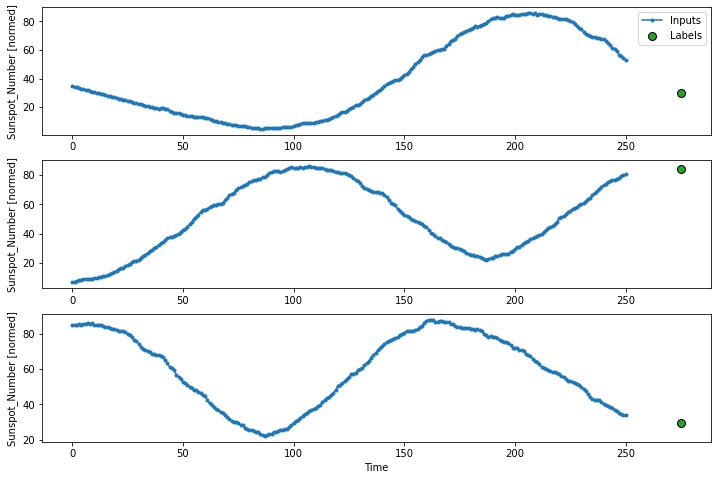

In [12]:
w1.plot()

## Create tf.data.Datasets

In [13]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [14]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.example = example

In [15]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [16]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 2)
Labels shape (batch, time, features): (32, 1, 1)


## Single Step Models

The simplest implementation: where we just predict a single value

In [17]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Sunspot_Number'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Sunspot_Number']

In [18]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 2)
Labels shape (batch, time, features): (32, 1, 1)


## Baseline

Performance baseline as a comparison for future models

In [19]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [20]:
baseline = Baseline(label_index=column_indices['Sunspot_Number'])

baseline.compile(loss=loss,
                 metrics=metric)

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)

16/16 [==============================] - 0s 7ms/step - loss: 1.0775 - mae: 1.0775


In [21]:
wide_window = WindowGenerator(
    input_width=100, label_width=100, shift=1,
    label_columns=['Sunspot_Number'])

#wide_window

In [22]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 100, 2)
Output shape: (32, 100, 1)


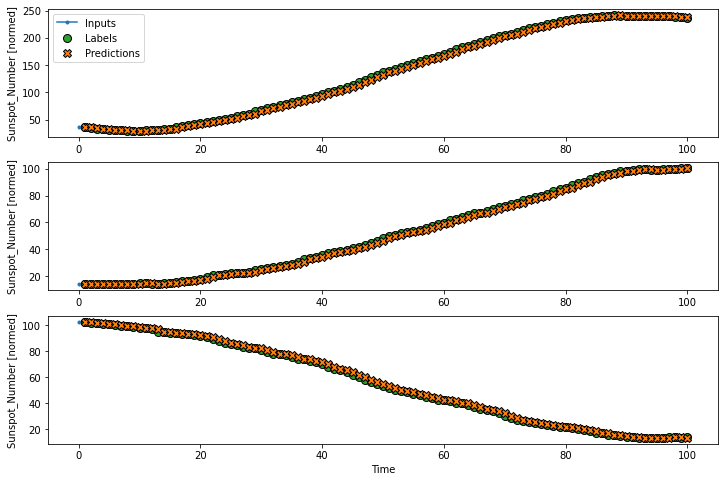

In [23]:
wide_window.plot(baseline)

In [24]:
MAX_EPOCHS = 500

def compile_and_fit(model, window, patience=15):
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=loss,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=metric)

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

**Note:** I experimented with different loss and metric (notably *Huber* and *mae*), but the above combination provided the optimal results

In [25]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding='causal',
                          activation='relu'),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(num_features)
])

In [26]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 100, 2)
Output shape: (32, 100, 2)


13/13 [==============================] - 0s 22ms/step - loss: 4.2623 - mae: 4.2623


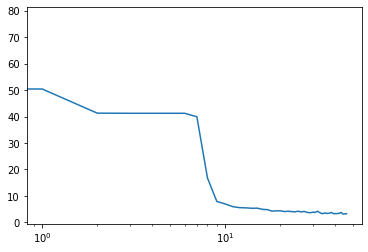

In [27]:
import IPython
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
plt.semilogx(history.history["loss"]);

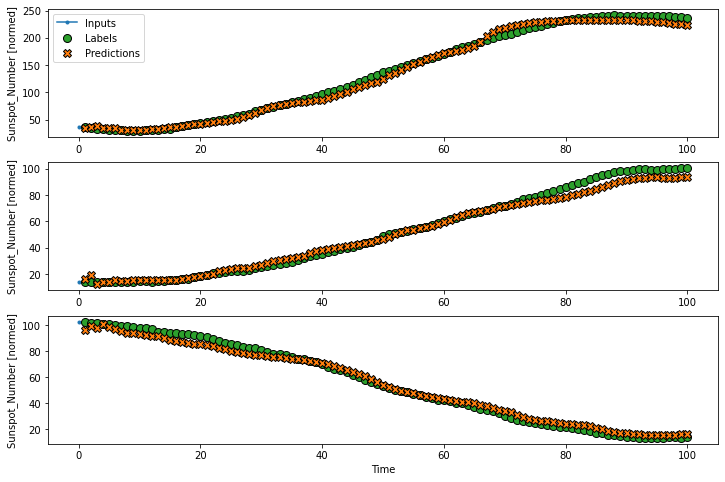

In [28]:
wide_window.plot(lstm_model)

## Multi-step Models

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

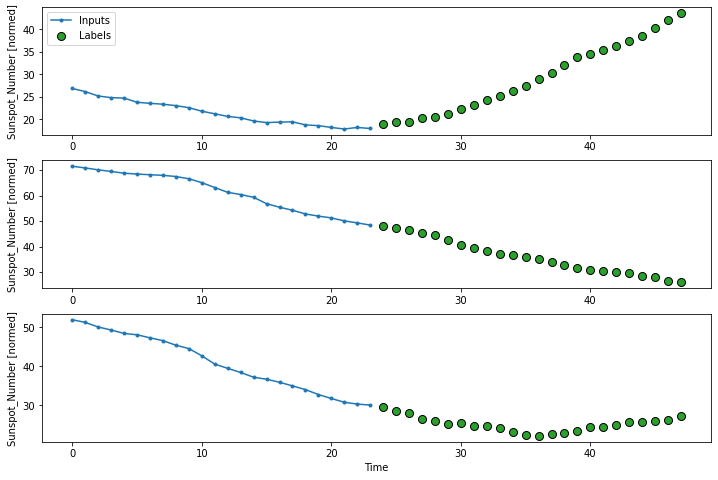

In [29]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [30]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

14/14 [==============================] - 0s 13ms/step - loss: 6.8793 - mae: 6.8793


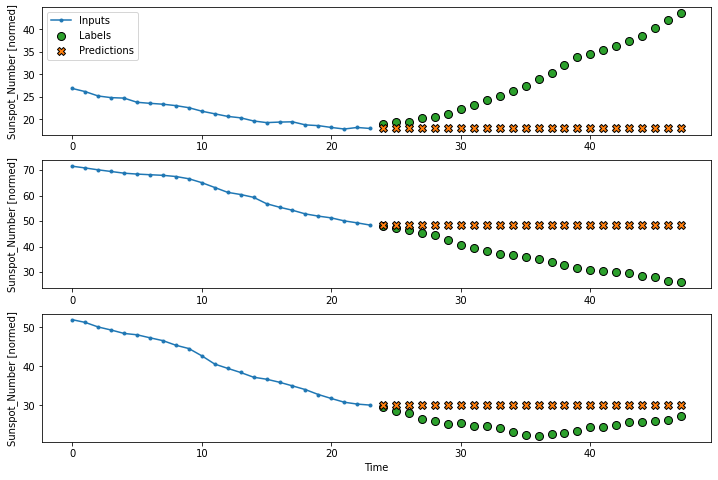

In [31]:
last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=loss,
                      metrics=metric)

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_window.plot(last_baseline)

14/14 [==============================] - 0s 8ms/step - loss: 13.0679 - mae: 13.0679


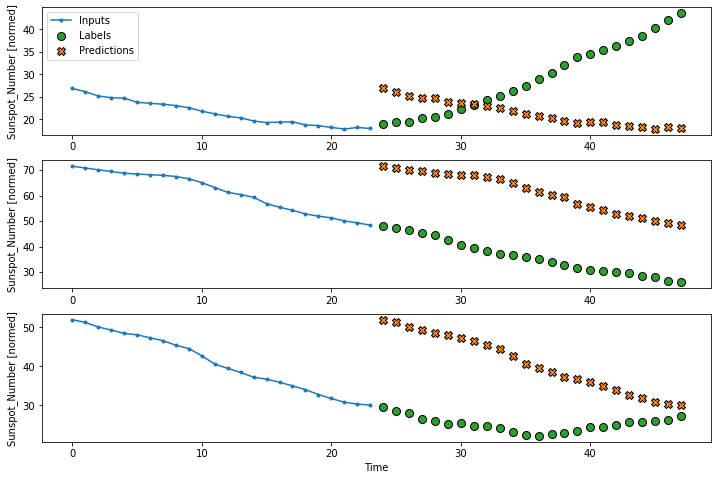

In [32]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=loss,
                        metrics=metric)

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_window.plot(repeat_baseline)

14/14 [==============================] - 0s 10ms/step - loss: 70.6756 - mae: 70.6756


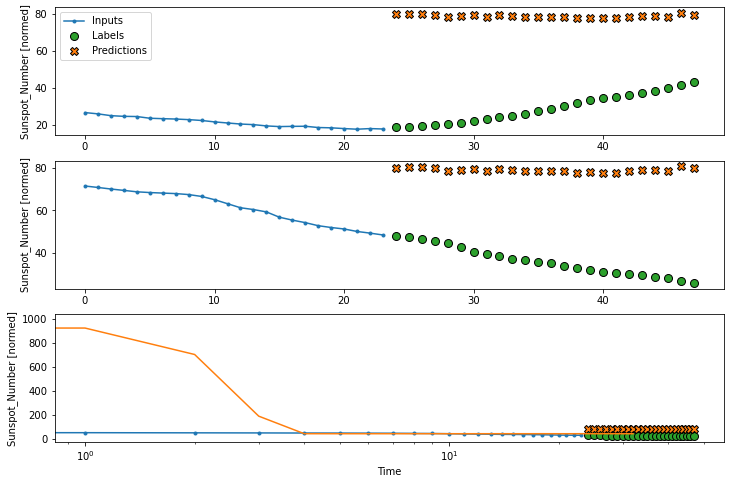

In [33]:
multi_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding='causal',
                          activation='relu'),
    tf.keras.layers.LSTM(64, return_sequences=True),  # Set return_sequences=True here
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_window.plot(multi_lstm_model)
plt.semilogx(history.history["loss"]);

# Autoregressive Model

In [58]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [59]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [60]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [61]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 2])

In [62]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

In [63]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 2)


In [67]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.conv1d = tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu')
        self.lstm_cell1 = tf.keras.layers.LSTMCell(units)
        self.lstm_cell2 = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn1 = tf.keras.layers.RNN(self.lstm_cell1, return_state=True)
        self.lstm_rnn2 = tf.keras.layers.RNN(self.lstm_cell2, return_state=True)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu')
        self.dense2 = tf.keras.layers.Dense(16, activation='relu')
        self.dense3 = tf.keras.layers.Dense(num_features)

    def warmup(self, inputs):
        x = self.conv1d(inputs)
        x, *state1 = self.lstm_rnn1(x)
        x, *state2 = self.lstm_rnn2(x)
        x = self.dense1(x)
        x = self.dense2(x)
        prediction = self.dense3(x)
        return prediction, state1, state2

    def call(self, inputs, training=None):
        predictions = []
        prediction, state1, state2 = self.warmup(inputs)
        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state1 = self.lstm_cell1(x, states=state1, training=training)
            x, state2 = self.lstm_cell2(x, states=state2, training=training)
            x = self.dense1(x)
            x = self.dense2(x)
            prediction = self.dense3(x)
            predictions.append(prediction)

        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

    def predict_autoregressive(self, inputs, out_steps, training=None):
        predictions = []
        prediction, state1, state2 = self.warmup(inputs)
        predictions.append(prediction)

        # Reshape the last prediction to match the input shape
        last_prediction = tf.expand_dims(prediction[:,-1,:], 1)

        for n in range(1, out_steps):
            x = last_prediction
            x, state1 = self.lstm_cell1(x, states=state1, training=training)
            x, state2 = self.lstm_cell2(x, states=state2, training=training)
            x = self.dense1(x)
            x = self.dense2(x)
            prediction = self.dense3(x)
            predictions.append(prediction)

            # Update the last prediction
            last_prediction = tf.expand_dims(prediction[:,-1,:], 1)

        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

In [68]:
# Train the model
model.compile(optimizer='adam', loss='mse')
model.fit(train_data, epochs=10, validation_data=val_data)

# Make autoregressive predictions
input_data = train_sf  # Prepare your input data for prediction (e.g., a single sequence or a batch of sequences)
out_steps = OUT_STEPS   # Specify the number of steps you want to predict
predictions = model.predict_autoregressive(input_data, out_steps)


NameError: name 'model' is not defined

In [69]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_window.plot(feedback_model)

Epoch 1/500
101/101 [==============================] - 161s 2s/step - loss: 983.9924 - mae: 983.9921 - val_loss: 1025.0590 - val_mae: 1025.0590
Epoch 2/500
101/101 [==============================] - 164s 2s/step - loss: 980.4539 - mae: 980.4530 - val_loss: 1021.9377 - val_mae: 1021.9377
Epoch 3/500
101/101 [==============================] - 211s 2s/step - loss: 977.2136 - mae: 977.2136 - val_loss: 1019.2242 - val_mae: 1019.2241
Epoch 4/500
101/101 [==============================] - 212s 2s/step - loss: 974.1576 - mae: 974.1572 - val_loss: 1016.6549 - val_mae: 1016.6550
Epoch 5/500
101/101 [==============================] - 172s 2s/step - loss: 971.1979 - mae: 971.1978 - val_loss: 1014.2067 - val_mae: 1014.2066
Epoch 6/500
101/101 [==============================] - 172s 2s/step - loss: 968.3476 - mae: 968.3477 - val_loss: 1011.8636 - val_mae: 1011.8636
Epoch 7/500
101/101 [==============================] - 98s 961ms/step - loss: 965.6166 - mae: 965.6164 - val_loss: 1009.6193 - val_mae: 

KeyboardInterrupt: 

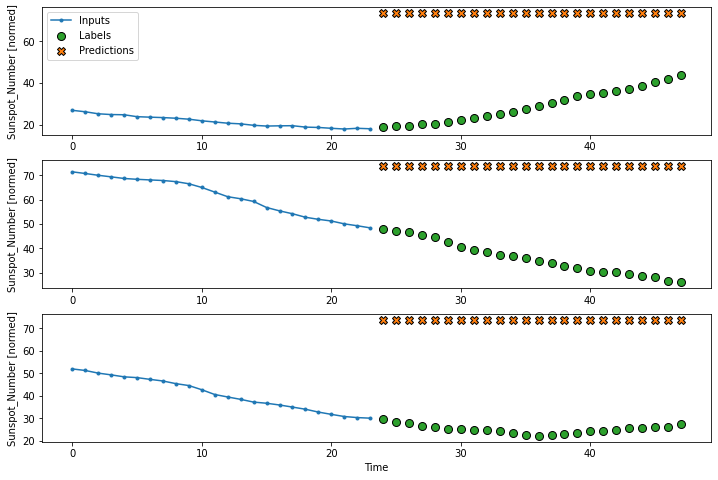

In [70]:
multi_window.plot(feedback_model)